#Text Classifier using Naive Bayes Theorem

####Name: Mayukha Thumiki
####UTA ID: 1002055616

###References:
#####https://stackoverflow.com/questions/22588316/pandas-applying-regex-to-replace-values
#####https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
#####https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
#####https://stackoverflow.com/questions/65413876/removing-stopwords-from-list-of-lists
#####https://karthikvadloori.wixsite.com/home/post/text-classifier-ford-sentence-classification-using-nbc
#####https://medium.com/@rangavamsi5/na%C3%AFve-bayes-algorithm-implementation-from-scratch-in-python-7b2cc39268b9
#####https://www.kaggle.com/code/hamishisham/sentiment-analysis-using-sentiwordnet-updated/notebook

###Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

from google.colab import drive
from sklearn.model_selection import train_test_split

import numpy as np
import nltk
from nltk import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.corpus import gutenberg
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from typing import List, Dict, Tuple
import itertools

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import classification_report as cr
from sklearn.metrics import confusion_matrix as cm

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


###Understanding the dataset

In [3]:
movie_data = pd.read_csv('/content/gdrive/MyDrive/NBC/rt_reviews.csv', encoding='latin1')

In [4]:
movie_data.head()

,Freshness,Review
0,fresh,"Manakamana doesn't answer any questions, yet ..."
1,fresh,Wilfully offensive and powered by a chest-thu...
2,rotten,It would be difficult to imagine material mor...
3,rotten,Despite the gusto its star brings to the role...
4,rotten,If there was a good idea at the core of this ...


In [5]:
print(movie_data.shape)

(480000, 2)


In [6]:
movie_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480000 entries, 0 to 479999
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Freshness  480000 non-null  object
 1   Review     480000 non-null  object
dtypes: object(2)
memory usage: 7.3+ MB


In [7]:
movie_data.isnull().any()

Freshness    False
Review       False
dtype: bool

In [8]:
movie_data.reset_index(inplace=True)
movie_data.head(10)

,index,Freshness,Review
0,0,fresh,"Manakamana doesn't answer any questions, yet ..."
1,1,fresh,Wilfully offensive and powered by a chest-thu...
2,2,rotten,It would be difficult to imagine material mor...
3,3,rotten,Despite the gusto its star brings to the role...
4,4,rotten,If there was a good idea at the core of this ...
5,5,rotten,"Gleeson goes the Hallmark Channel route, dama..."
6,6,fresh,It was the height of satire in 1976: dark as ...
7,7,rotten,"Everyone in ""The Comedian"" deserves a better ..."
8,8,rotten,Actor encourages grumpy Christians to embrace...
9,9,fresh,"Slight, contained, but ineffably soulful."


In [9]:
classes = movie_data['Freshness'].unique()
print(classes)

['fresh' 'rotten']


In [10]:
#Reference: https://stackoverflow.com/questions/22588316/pandas-applying-regex-to-replace-values
movie_data = movie_data.replace("[^a-zA-Z]+", " ", regex=True)

###Splitting and processing the dataset

In [11]:
#Reference: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
train_data,test_data =  train_test_split(movie_data, test_size=0.2, random_state=1)
test_data, valid_data = train_test_split(test_data, test_size=0.5, random_state=1)
print("Size of Train Data: {}".format(len(train_data.index)))
print("Size of Test Data: {}".format(len(test_data.index)))
print("Size of Validation Data: {}".format(len(valid_data.index)))

Size of Train Data: 384000
Size of Test Data: 48000
Size of Validation Data: 48000


In [12]:
train_data['Freshness'].value_counts()

fresh     192124
rotten    191876
Name: Freshness, dtype: int64

In [13]:
#For Lemmatization
import nltk
nltk.download('punkt')
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [14]:
#Reference: https://karthikvadloori.wixsite.com/home/post/text-classifier-ford-sentence-classification-using-nbc
#Reference: https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
def get_frequency(df, freshness_type="total", voclist=None) -> Tuple[Dict[str, int], FreqDist]:
    if freshness_type != "total":
        df = df[df["Freshness"] == freshness_type]

    reviews = df["Review"].tolist()
    words = list(itertools.chain.from_iterable([review.split() for review in reviews]))

    # Lemmatize the words using WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    lemmas = (lemmatizer.lemmatize(word.lower()) for word in words if word.isalpha())

    # Create a frequency distribution of the lemmas
    freq_dist = FreqDist(lemmas)

    return dict(freq_dist), freq_dist

In [15]:
train_vocdic, train_freq_dist=get_frequency(train_data)

In [16]:
print("Number of unique words in all the sentences after lemmatization:",len(train_freq_dist))

Number of unique words in all the sentences after lemmatization: 71716


In [17]:
all_train_freq_dist = train_freq_dist.items() #For probability calculation after smoothing i.e. before the removal of stopwords
all_train_freq_list = list(train_freq_dist.items())
all_train_vocdic = train_vocdic

In [18]:
train_freq_dist_list = list(train_freq_dist.items()) #For likelihood probability
print(train_freq_dist_list)

[('of', 249549), ('the', 439047), ('featured', 89), ('cast', 6677), ('only', 12510), ('woodley', 111), ('really', 7865), ('achieves', 452), ('any', 9802), ('lasting', 294), ('impact', 1009), ('in', 123495), ('this', 65722), ('episode', 1059), ('although', 2545), ('ham', 297), ('fisted', 142), ('writing', 1290), ('sometimes', 2960), ('leaf', 1888), ('her', 9658), ('a', 377799), ('little', 11429), ('too', 16749), ('exposed', 98), ('is', 153126), ('perhaps', 2525), ('weakest', 176), ('hirani', 3), ('s', 163661), ('film', 71002), ('his', 25719), ('trademark', 246), ('humour', 1207), ('sparse', 87), ('and', 255241), ('inspite', 1), ('anushka', 2), ('sharma', 19), ('spirited', 656), ('portrayal', 696), ('reporter', 101), ('who', 17029), ('help', 2260), ('pk', 6), ('khan', 86), ('over', 8808), ('earnest', 767), ('performance', 13546), ('protagonist', 1237), ('tedious', 1153), ('watch', 4386), ('rustic', 24), ('classic', 3410), ('john', 2194), ('ford', 441), ('duke', 109), ('first', 9130), ('b

In [19]:
#Reference: https://stackoverflow.com/questions/65413876/removing-stopwords-from-list-of-lists

#Removal of stopwords
# Download stopwords
nltk.download('stopwords')

def stop_words_removal(freq_dist_list, vocdic):
  stop_words = stopwords.words('english')
  freq_dist_list_copy = freq_dist_list.copy() 
  for sublist in freq_dist_list_copy:
    if sublist[0] in stop_words:
      freq_dist_list.remove(sublist)

  for sw in stop_words:
    if sw in vocdic:
      vocdic.pop(sw)
  return freq_dist_list, vocdic

train_freq_dist_list, train_vocdic = stop_words_removal(train_freq_dist_list, train_vocdic)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [20]:
train_freq_dist_list[:10]

[('featured', 89),
 ('cast', 6677),
 ('woodley', 111),
 ('really', 7865),
 ('achieves', 452),
 ('lasting', 294),
 ('impact', 1009),
 ('episode', 1059),
 ('although', 2545),
 ('ham', 297)]

In [21]:
print('a' in train_vocdic.keys())
print('marshall' in train_vocdic.keys())

False
True


###Building bag of vocabulary

In [22]:
train_vocabulary=[]
for lemma, count in train_freq_dist_list:
    train_vocabulary.append(lemma)
print(train_vocabulary)

['featured', 'cast', 'woodley', 'really', 'achieves', 'lasting', 'impact', 'episode', 'although', 'ham', 'fisted', 'writing', 'sometimes', 'leaf', 'little', 'exposed', 'perhaps', 'weakest', 'hirani', 'film', 'trademark', 'humour', 'sparse', 'inspite', 'anushka', 'sharma', 'spirited', 'portrayal', 'reporter', 'help', 'pk', 'khan', 'earnest', 'performance', 'protagonist', 'tedious', 'watch', 'rustic', 'classic', 'john', 'ford', 'duke', 'first', 'big', 'one', 'ironic', 'last', 'image', 'pedro', 'almodovar', 'bad', 'education', 'offer', 'u', 'close', 'spanish', 'word', 'pasi', 'n', 'feel', 'far', 'rarefied', 'precise', 'g', 'blue', 'try', 'hard', 'part', 'comment', 'genre', 'crime', 'story', 'doe', 'succeed', 'either', 'atom', 'egoyan', 'bold', 'often', 'ludicrous', 'remember', 'play', 'like', 'mash', 'terminator', 'marathon', 'man', 'memento', 'filtered', 'lens', 'old', 'twilight', 'zone', 'ha', 'good', 'professional', 'look', 'kiki', 'serf', 'reminder', 'american', 'western', 'society', 

###Calculating probability of occurrence of a word

In [23]:
#marginal probability calculation
train_wfreqdf_total=pd.DataFrame(train_freq_dist_list,columns=["Vocabulary", "Total_Frequency"])
train_wfreqdf_total.head()

,Vocabulary,Total_Frequency
0,featured,89
1,cast,6677
2,woodley,111
3,really,7865
4,achieves,452


In [24]:
sum_of_values = sum(train_vocdic.values())
print(sum_of_values)

4821291


In [25]:
#Reference: https://karthikvadloori.wixsite.com/home/post/text-classifier-ford-sentence-classification-using-nbc
st=True
marginal_prob = (
    train_wfreqdf_total.set_index("Vocabulary")
    .fillna(0) if st else train_wfreqdf_total.set_index("Vocabulary")
)

marginal_prob = marginal_prob.apply(lambda x: x/sum_of_values, axis=1)
marginal_prob

,Total_Frequency
Vocabulary,
featured,1.845979e-05
cast,1.384899e-03
woodley,2.302288e-05
really,1.631306e-03
achieves,9.375082e-05
...,...
kingmaking,2.074133e-07
remolding,2.074133e-07
bagging,2.074133e-07


###Calculating Conditional probability based on the sentiment

In [26]:
#Likelihod probability calculation
train_wfreqdf=pd.DataFrame(train_vocabulary,columns=["Vocabulary"])
train_wfreqdf.head(10)

,Vocabulary
0,featured
1,cast
2,woodley
3,really
4,achieves
5,lasting
6,impact
7,episode
8,although
9,ham


In [27]:
freshness_count = train_data['Freshness'].value_counts()
print("Fresh : {}".format(freshness_count.values[0]), "\tRotten : {}".format(freshness_count.values[1]))

for freshness in freshness_count.index:
    print("\nFreshness: {}".format(freshness))
    vocdic_type, freq_cnt_type=get_frequency(train_data, freshness, voclist = train_vocabulary)
    freq_dist_list=list(freq_cnt_type.items())
    freq_cnt_type, vocdic_type = stop_words_removal(freq_dist_list, vocdic_type)
    temp = [(lemma, freshness) for lemma, count in freq_cnt_type]
    voctypedf=pd.DataFrame(vocdic_type.items(),columns=["Vocabulary",freshness])
    train_wfreqdf=train_wfreqdf.merge(voctypedf,how="left",on="Vocabulary")

print(len(train_wfreqdf))
train_wfreqdf.head(20)

Fresh : 192124 	Rotten : 191876

Freshness: fresh

Freshness: rotten
71567


,Vocabulary,fresh,rotten
0,featured,37.0,52.0
1,cast,3665.0,3012.0
2,woodley,62.0,49.0
3,really,3151.0,4714.0
4,achieves,293.0,159.0
5,lasting,142.0,152.0
6,impact,532.0,477.0
7,episode,317.0,742.0
8,although,1349.0,1196.0
9,ham,43.0,254.0


In [28]:
st=True
likelihoodprob = (
    train_wfreqdf.set_index("Vocabulary")
    .fillna(0) if st else train_wfreqdf.set_index("Vocabulary")
)
likelihoodprob

,fresh,rotten
Vocabulary,,
featured,37.0,52.0
cast,3665.0,3012.0
woodley,62.0,49.0
really,3151.0,4714.0
achieves,293.0,159.0
...,...,...
kingmaking,1.0,0.0
remolding,0.0,1.0
bagging,0.0,1.0


In [29]:
sum_fresh = likelihoodprob['fresh'].sum()
sum_rotten = likelihoodprob['rotten'].sum()
print('Sum of fresh : {}'.format(sum_fresh))
print('Sum of rotten : {}'.format(sum_rotten))

Sum of fresh : 2453902.0
Sum of rotten : 2367389.0


In [ ]:
if 'fresh' in likelihoodprob.columns:
  likelihoodprob = likelihoodprob.apply(lambda x: x/sum_fresh, axis=1)
else:
  likelihoodprob = likelihoodprob.apply(lambda x: x/sum_rotten, axis=1)
likelihoodprob

###Testing the algorithm on sample user given input data

In [48]:
review = "good one"
words=review.split()
print("List of words in review : {}".format(list(words)))

prob_fresh=1
prob_rotten=1
prior_type = train_data['Freshness'].value_counts(normalize=True).to_frame().T
p_of_fresh=prior_type.iloc[0, 0]
p_of_rotten=prior_type.iloc[0, 1]

for wd in words:
  element_fresh = likelihoodprob.loc[wd, "fresh"]
  prob_fresh*=element_fresh
  element_rotten = likelihoodprob.loc[wd, "rotten"]
  prob_rotten*=element_rotten

final_fresh_prob=prob_fresh*p_of_fresh
final_rotten_prob=prob_rotten*p_of_rotten
print("Prob(words in review|fresh) = {}".format(final_fresh_prob), "\tProb(words in review|rotten) = {}".format(final_rotten_prob))

sol=[]
if final_fresh_prob > final_rotten_prob:
  sol.append('fresh')
else:
  sol.append('rotten')
print("Prediction : {}".format(sol))

List of words in review : ['good', 'one']
Prob(words in review|fresh) = 1.2742452795650694e-05 	Prob(words in review|rotten) = 9.99335060352259e-06
Prediction : ['fresh']


###Testing using validation data

In [68]:
#Reference: https://medium.com/@rangavamsi5/na%C3%AFve-bayes-algorithm-implementation-from-scratch-in-python-7b2cc39268b9

valid_prediction = []

for s in valid_data['Review']:
    words = s.split()
    fresh_prob = 1.0
    rotten_prob = 1.0

    for w in words:
        if w in train_vocabulary:
            fresh_prob *= likelihoodprob.loc[w, 'fresh']
            rotten_prob *= likelihoodprob.loc[w, 'rotten']
    fresh_prob *= prior_type.loc['Freshness', 'fresh']
    rotten_prob *= prior_type.loc['Freshness', 'rotten']
    if fresh_prob > rotten_prob:
        valid_prediction.append('fresh')
    else:
        valid_prediction.append('rotten')

print('Generated Accuracy for Valid Data: {}'.format(accuracy_score(valid_data["Freshness"], valid_prediction)))

Generated Accuracy for Valid Data: 0.7763333333333333


In [69]:
print('Generated Accuracy for Valid Data: {}'.format(accuracy_score(valid_data["Freshness"], valid_prediction)))

Generated Accuracy for Valid Data: 0.7763333333333333


###Repeating the above steps by performing Laplacian smoothing

In [76]:
sm_train_vocabulary=[]
for lemma, count in all_train_freq_list:
    sm_train_vocabulary.append(lemma)
print(sm_train_vocabulary)

['of', 'the', 'featured', 'cast', 'only', 'woodley', 'really', 'achieves', 'any', 'lasting', 'impact', 'in', 'this', 'episode', 'although', 'ham', 'fisted', 'writing', 'sometimes', 'leaf', 'her', 'a', 'little', 'too', 'exposed', 'is', 'perhaps', 'weakest', 'hirani', 's', 'film', 'his', 'trademark', 'humour', 'sparse', 'and', 'inspite', 'anushka', 'sharma', 'spirited', 'portrayal', 'reporter', 'who', 'help', 'pk', 'khan', 'over', 'earnest', 'performance', 'protagonist', 'tedious', 'watch', 'rustic', 'classic', 'john', 'ford', 'duke', 'first', 'big', 'one', 'it', 'ironic', 'that', 'last', 'image', 'pedro', 'almodovar', 'bad', 'education', 'offer', 'u', 'close', 'up', 'spanish', 'word', 'pasi', 'n', 'because', 'feel', 'far', 'rarefied', 'precise', 'for', 'own', 'g', 'out', 'blue', 'try', 'hard', 'to', 'both', 'be', 'part', 'comment', 'on', 'genre', 'crime', 'story', 'doe', 'not', 'succeed', 'at', 'either', 'atom', 'egoyan', 'bold', 'but', 'often', 'ludicrous', 'remember', 'play', 'like', 

In [77]:
sm_train_wfreqdf=pd.DataFrame(sm_train_vocabulary,columns=["Vocabulary"])
sm_train_wfreqdf.head(10)

,Vocabulary
0,of
1,the
2,featured
3,cast
4,only
5,woodley
6,really
7,achieves
8,any
9,lasting


In [78]:
freshness_count = train_data['Freshness'].value_counts()
print("Fresh : {}".format(freshness_count.values[0]), "\tRotten : {}".format(freshness_count.values[1]))

for freshness in freshness_count.index:
    print("\nFreshness: {}".format(freshness))
    vocdic_type, freq_cnt_type=get_frequency(train_data, freshness, voclist = sm_train_vocabulary)

    freq_dist_list=list(freq_cnt_type.items())

    temp = [(lemma, freshness) for lemma, count in freq_dist_list]
    voctypedf=pd.DataFrame(vocdic_type.items(),columns=["Vocabulary",freshness])
    sm_train_wfreqdf=sm_train_wfreqdf.merge(voctypedf,how="left",on="Vocabulary")

print(len(sm_train_wfreqdf))
sm_train_wfreqdf.head(20)

Fresh : 192124 	Rotten : 191876

Freshness: fresh

Freshness: rotten
71716


,Vocabulary,fresh,rotten
0,of,133281.0,116268.0
1,the,220965.0,218082.0
2,featured,37.0,52.0
3,cast,3665.0,3012.0
4,only,4414.0,8096.0
5,woodley,62.0,49.0
6,really,3151.0,4714.0
7,achieves,293.0,159.0
8,any,3739.0,6063.0
9,lasting,142.0,152.0


In [79]:
sm_train_wfreqdf

,Vocabulary,fresh,rotten
0,of,133281.0,116268.0
1,the,220965.0,218082.0
2,featured,37.0,52.0
3,cast,3665.0,3012.0
4,only,4414.0,8096.0
...,...,...,...
71711,kingmaking,1.0,NaN
71712,remolding,NaN,1.0
71713,bagging,NaN,1.0
71714,vaxxers,1.0,NaN


In [80]:
#Laplacian Smoothing has been performed here by adding 1 to all words to eliminate NaN values
st=True
sm_likelihoodprob = (
    sm_train_wfreqdf.set_index("Vocabulary")
    .fillna(0) 
    .add(1)
    if st else sm_train_wfreqdf.set_index("Vocabulary")
)
sm_likelihoodprob

,fresh,rotten
Vocabulary,,
of,133282.0,116269.0
the,220966.0,218083.0
featured,38.0,53.0
cast,3666.0,3013.0
only,4415.0,8097.0
...,...,...
kingmaking,2.0,1.0
remolding,1.0,2.0
bagging,1.0,2.0


In [81]:
sm_sum_fresh = sm_likelihoodprob['fresh'].sum()
sm_sum_rotten = sm_likelihoodprob['rotten'].sum()
print('Sum of fresh : {}'.format(sm_sum_fresh))
print('Sum of rotten : {}'.format(sm_sum_rotten))

Sum of fresh : 4461794.0
Sum of rotten : 4376763.0


In [82]:
if 'fresh' in sm_likelihoodprob.columns:
  sm_likelihoodprob = sm_likelihoodprob.apply(lambda x: x/sm_sum_fresh, axis=1)
else:
  sm_likelihoodprob = sm_likelihoodprob.apply(lambda x: x/sm_sum_rotten, axis=1)
sm_likelihoodprob

,fresh,rotten
Vocabulary,,
of,2.987184e-02,2.605880e-02
the,4.952403e-02,4.887787e-02
featured,8.516754e-06,1.187863e-05
cast,8.216426e-04,6.752889e-04
only,9.895123e-04,1.814741e-03
...,...,...
kingmaking,4.482502e-07,2.241251e-07
remolding,2.241251e-07,4.482502e-07
bagging,2.241251e-07,4.482502e-07


In [ ]:
sm_valid_prediction = []

for s in valid_data['Review']:
    words = s.split()
    fresh_prob = 1.0
    rotten_prob = 1.0

    for w in words:
        if w in sm_train_vocabulary:
            fresh_prob *= sm_likelihoodprob.loc[w, 'fresh']
            rotten_prob *= sm_likelihoodprob.loc[w, 'rotten']
    fresh_prob *= prior_type.loc['Freshness', 'fresh']
    rotten_prob *= prior_type.loc['Freshness', 'rotten']
    if fresh_prob > rotten_prob:
        sm_valid_prediction.append('fresh')
    else:
        sm_valid_prediction.append('rotten')

print('Generated Accuracy for Test Data: {}'.format(accuracy_score(valid_data["Freshness"], sm_valid_prediction)))

In [66]:
print('Generated Accuracy for Test Data: {}'.format(accuracy_score(valid_data["Freshness"], sm_valid_prediction)))

Generated Accuracy for Test Data: 0.7797083333333333


###Testing using Test Data

In [ ]:
#Before Smoothing
test_prediction = []

for s in test_data['Review']:
    words = s.split()
    fresh_prob = 1.0
    rotten_prob = 1.0

    for w in words:
        if w in train_vocabulary:
            fresh_prob *= likelihoodprob.loc[w, 'fresh']
            rotten_prob *= likelihoodprob.loc[w, 'rotten']
    fresh_prob *= prior_type.loc['Freshness', 'fresh']
    rotten_prob *= prior_type.loc['Freshness', 'rotten']
    if fresh_prob > rotten_prob:
        test_prediction.append('fresh')
    else:
        test_prediction.append('rotten')

print('Generated Accuracy for Test Data: {}'.format(accuracy_score(test_data["Freshness"], test_prediction)))

In [ ]:
print('Generated Accuracy for Test Data: {}'.format(accuracy_score(test_data["Freshness"], test_prediction)))

Generated Accuracy for Test Data: 0.7748958333333333


In [75]:
#After Smoothing
sm_test_prediction = []

for s in test_data['Review']:
    words = s.split()
    fresh_prob = 1.0
    rotten_prob = 1.0

    for w in words:
        if w in sm_train_vocabulary:
            fresh_prob *= sm_likelihoodprob.loc[w, 'fresh']
            rotten_prob *= sm_likelihoodprob.loc[w, 'rotten']
    fresh_prob *= prior_type.loc['Freshness', 'fresh']
    rotten_prob *= prior_type.loc['Freshness', 'rotten']
    if fresh_prob > rotten_prob:
        sm_test_prediction.append('fresh')
    else:
        sm_test_prediction.append('rotten')

print('Generated Accuracy for Test Data: {}'.format(accuracy_score(test_data["Freshness"], sm_test_prediction)))

KeyError: ignored

###Comparison of performance after and before smoothing

In [74]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(test_data["Freshness"], test_prediction, pos_label=1)
recall = recall_score(test_data["Freshness"], test_prediction, pos_label=1)
f1_score = f1_score(test_data["Freshness"], test_prediction, pos_label=1)

#sm_precision = precision_score(test_data["Freshness"], sm_test_prediction, pos_label=1)
#sm_recall = recall_score(test_data["Freshness"], sm_test_prediction, pos_label=1)
#sm_f1_score = f1_score(test_data["Freshness"], sm_test_prediction, pos_label=1)


In [70]:




#Before Smoothing
model1_val_acc = list(accuracy_score(valid_data["Freshness"], valid_prediction))
model1_test_acc = list(accuracy_score(test_data["Freshness"], test_prediction))


#After Smoothing
model2_val_acc = list(accuracy_score(valid_data["Freshness"], sm_valid_prediction))
model2_test_acc = list(accuracy_score(test_data["Freshness"], sm_test_prediction))

#Plot data
plt.plot(model1_val_acc, label='Before Smoothing Validation Accuracy')
plt.plot(model1_test_acc, label='Before Smoothing Test Accuracy')
plt.plot(model2_val_acc, label='After Smoothing Validation Accuracy')
plt.plot(model2_test_acc, label='After Smoothing Test Accuracy')

# Plot title and labels
plt.title('Model Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

TypeError: ignored

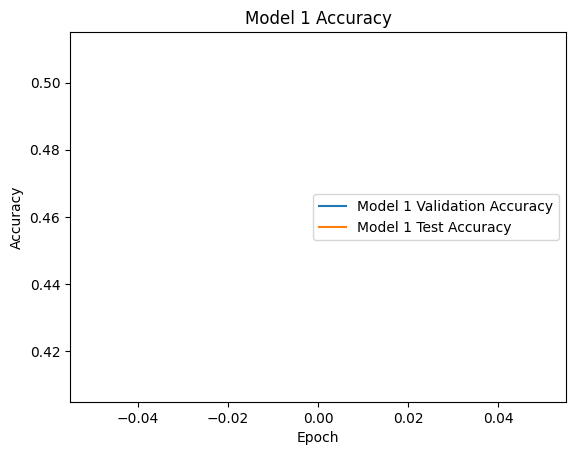

In [71]:
'''import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# generate example data
valid_data = {"Freshness": np.random.randint(0, 2, size=100)}
test_data = {"Freshness": np.random.randint(0, 2, size=100)}
valid_prediction = np.random.randint(0, 2, size=100)
test_prediction = np.random.randint(0, 2, size=100)

# compute accuracy scores
model1_val_acc = [accuracy_score(valid_data["Freshness"], valid_prediction)]
model1_test_acc = [accuracy_score(test_data["Freshness"], test_prediction)]

# plot data
plt.plot(model1_val_acc, label='Model 1 Validation Accuracy')
plt.plot(model1_test_acc, label='Model 1 Test Accuracy')

# add title and labels
plt.title('Model 1 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# show plot
plt.show()'''

###Top 10 words that predicted each class

In [ ]:
# Top 10 words under "fresh"
top_fresh = likelihoodprob.nlargest(10, "fresh").index.tolist()

# Top 10 words under "rotten"
top_rotten = likelihoodprob.nlargest(10, "rotten").index.tolist()

print("The Top 10 words that predict fresh : {}".format(top_fresh))
print("The Top 10 words that predict rotten : {}".format(top_rotten))

The Top 10 words that predict fresh : ['film', 'movie', 'one', 'ha', 'story', 'like', 'make', 'performance', 'time', 'character']
The Top 10 words that predict rotten : ['film', 'movie', 'like', 'one', 'ha', 'much', 'story', 'make', 'character', 'feel']
